CS524: Introduction to Optimization Lecture 31
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison 

## November 13, 2024
--------------


In [1]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card

import sys
import numpy as np
import pandas as pd

## Cross-validation is a general tool

So far we’ve looked at cross-validation for estimation under squared error loss, but it applies much more broadly than this.

For an arbitrary loss $\ell(y_i-\phi(a_i))$, the cross-validation estimate of
prediction error under $\ell$ is
$$ \frac{1}{n} \sum_{k=1}^K \sum_{i \in F_k} \ell(y_i-\phi^{-k}(a_i)) $$

E.g., for classification, when each $y_i \in \{0, 1\}$, we might want to use
the 0-1 loss
$$ \ell(y_i-\phi(a_i)) = 
\begin{cases}
0 & \text{ if } y_i = \phi(a_i) \\
1 & \text{ if } y_i \neq \phi(a_i)
\end{cases}
$$
Cross-validation now gives us an estimate of misclassification error for a new observation. Usually in cross-validation for classification we try to balance the folds.

Example data is given in federal.gdx as training and testing data.   This is a data set pertaining to the classification of the federalist papers as being written by Madison or Hamilton.

We demonstrate a cross validation process to determine the best value of $\nu$.

In [2]:
m = gp.Container(load_from="federal.gdx")

# Sets
p,j,test,train = m.getSymbols(["p", "j", "test", "train"])

# Parameters
# Note that y(p) = 1 means Hamilton wrote it, -1 means Madison
A, y = m.getSymbols(["X", "Y"])

display(A.pivot())

,a,all,also,an,and,any,are,as,at,be,...,was,were,what,when,which,who,will,with,would,your
paper1,24.911032,1.016777,0.000000,3.050330,21.352312,2.541942,4.575496,11.184545,6.100661,19.318760,...,0.508388,1.016777,1.525165,0.000000,7.117438,1.016777,7.117438,2.541942,4.067107,0.0
paper2,21.691013,0.442674,3.541390,0.885347,5.312085,18.592297,3.098716,1.770695,8.853475,17.264277,...,0.885347,1.328021,1.770695,0.442674,6.640106,3.541390,10.181497,10.181497,4.426737,0.0
paper3,26.919243,1.994018,0.997009,1.994018,6.979063,22.931206,2.991027,2.991027,9.970090,23.928215,...,0.997009,1.994018,0.000000,5.982054,10.967098,0.000000,0.997009,3.988036,8.973081,0.0
paper4,13.848817,2.885170,5.193306,0.000000,6.924408,25.389498,2.885170,10.386613,11.540681,20.773226,...,0.000000,0.000000,2.308136,0.577034,11.540681,1.154068,3.462204,6.347374,2.885170,0.0
paper5,19.920319,3.984064,5.976096,1.328021,5.976096,19.920319,5.312085,2.656043,11.288180,23.904383,...,7.304117,1.328021,0.664011,0.664011,9.960159,8.632138,8.632138,5.312085,4.648074,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
paper114,22.311468,4.908523,1.784917,0.000000,6.247211,26.327532,2.677376,4.462294,11.601963,22.311468,...,1.784917,2.677376,2.677376,0.892459,7.139670,4.016064,4.908523,5.354753,8.478358,0.0
paper115,26.008669,2.667556,1.333778,0.000000,4.668223,40.346783,1.333778,9.003001,6.668890,20.340113,...,0.666889,0.000000,1.667222,0.666889,13.004334,3.001000,10.003334,3.667889,2.000667,0.0
paper116,18.155054,5.397449,4.416094,0.000000,6.378803,20.608440,5.397449,1.472031,9.322865,26.987242,...,0.000000,3.434740,0.981354,1.962709,10.794897,2.453386,2.944063,6.378803,17.664377,0.0
paper117,32.064129,2.004008,1.503006,0.000000,5.010020,24.549099,3.006012,4.008016,9.018036,20.040081,...,0.501002,1.002004,1.002004,1.002004,10.020041,2.505010,3.006012,7.515030,6.012024,0.0


In [3]:
nu = m.addParameter('nu')

i = m.addSet('i',domain=p,description='training examples')
delta = m.addVariable('delta','positive',domain=p)
w = m.addVariable('w','free',domain=j)
gamma = m.addVariable('gamma','free')

cons = m.addEquation('cons', domain=p)
cons[i] = y[i]*(Sum(j, A[i,j]*w[j]) - gamma) + delta[i] >= 1

svm = m.addModel('svm',
    equations=m.getEquations(),
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=nu*Sum(i, delta[i]) + 0.5*Sum(j, gpm.sqr(w[j]))
)

err = m.addSet('err',domain=p)

Following cell sets up the folds for cross-validation.  The set train is split into k subsets (or folds) that are randomly selected subsets of train.

We then use cross-validation to determine the CV error for each "trial" value of nu.

In [4]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv = []
for nuval in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    nu[:] = nuval
    err[p] = False
    for train_index, tune_index in kf.split(train.records):
        i.setRecords(train.records.loc[train_index])
        svm.solve(solver='conopt',output=None)
        i.setRecords(train.records.loc[tune_index])
        err[i].where[(Sum(j, A[i,j]*w.l[j]) - gamma.l) * y[i] < 0] = True
    cv.append(len(err.records)/len(train.records))
display(cv)

[0.04716981132075472,
 0.04716981132075472,
 0.04716981132075472,
 0.0660377358490566,
 0.16981132075471697,
 0.4716981132075472]

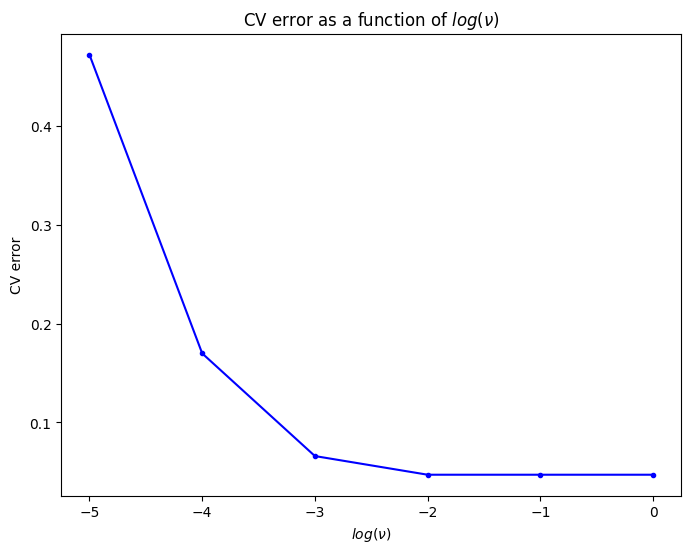

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("CV error as a function of $log(\\nu)$")
ax.set_xlabel("$log(\\nu)$")
ax.set_ylabel("CV error")
ax.plot(range(0,-6,-1),cv,"b.-");

Finally, we set the value of $\nu$ to the best one (from CV) and rerun the model using all the data, then generate predictions of the authors for each of the papers in the test set

In [6]:
# Evaluation at best value of nu
nu.setRecords(0.01)

pred = m.addParameter('pred',domain=['p'],description='prediction')
i[p] = train[p]
svm.solve()

pred[test] = gpm.sign(Sum(j, A[test,j]*w.l[j]) - gamma.l)
display(pred.records)
# predict unknown papers written by Madison (mostly)

,p,value
0,paper8,-1.0
1,paper17,-1.0
2,paper26,-1.0
3,paper32,-1.0
4,paper49,-1.0
5,paper58,-1.0
6,paper70,-1.0
7,paper76,-1.0
8,paper82,-1.0
9,paper97,1.0
